In [ ]:
from google.colab import drive
drive.mount('/content/drive')
working_path = '/content/drive/MyDrive/Colab Notebooks/torchtorch/'

Mounted at /content/drive


In [ ]:
pip install fastai --upgrade

In [ ]:
pip uninstall folium

In [ ]:
pip install folium==0.2.1

In [ ]:
import os
os.chdir(working_path)

In [ ]:
pip install -Uqq fastbook

In [ ]:
from fastbook import *

# 다중 레이블 분류
여러 종류의 레이블인 상황 + 찾고 싶은 종류의 물체가 전혀 없는 상황

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [ ]:
fns = get_image_files(path)
fns[:5]

(#5) [Path('/root/.fastai/data/pascal_2007/train/002519.jpg'),Path('/root/.fastai/data/pascal_2007/train/009655.jpg'),Path('/root/.fastai/data/pascal_2007/train/009100.jpg'),Path('/root/.fastai/data/pascal_2007/train/006959.jpg'),Path('/root/.fastai/data/pascal_2007/train/006765.jpg')]

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


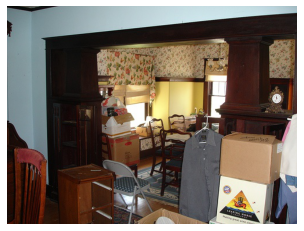

In [ ]:
im = plt.imread(path/'train'/'000005.jpg')
plt.imshow(im)
plt.axis('off')
plt.show()

## 데이터블록 구성
DataFrame -> DataLoaders<br>
(가능한 DataBlock API 사용을 권장 -> 간결성과 유연성 측면)

pytorch의 학습용 및 검증용 데이터셋을 표현하는 클래스
- Dataset : 단일 데이터를 표현하는 독립변수 및 종속변수 튜플
- DataLoader : 미니배치 스트림을 제공하는 반복자로, 각 미니배치는 여러 독립변수와 여러 종속변수에 대한 튜플로 구성

fastai에서 위 두 클래스를 기반으로 학습용 및 검증용 데이터셋을 함께 다루는 별도의 클래스
- Datasets : 학습용 및 검증용 Dataset을 포함하는 반복자
- DataLoaders : 학습용 및 검증용 DataLoader를 포함하는 객체

### Datasets

In [ ]:
def get_x(x): return path/'train'/x['fname']
def get_y(x): return x['labels'].split(' ')
def splitter(df):
    train = df.index[df['is_valid']==False].tolist()
    valid = df.index[df['is_valid']==True].tolist()
    return train,valid

dblock = DataBlock(get_x = get_x,        # input과 target 두 요소를 지정,
                   get_y = get_y,        # lambda를 지정할 수도 있으나 직렬화를 지원하지 않으므로 모델의 Learner를 다른 환경으로 내보내려면 def를 쓰는 것이 좋음
                   splitter = splitter   # 지정하지 않아도 디폴트로 train,valid set이 분리되나 원하는 형식대로 train,valid set을 분리할 수도 있음
                   )
# 실제 데이터 소스를 명시
dsets = dblock.datasets(df)
# 이렇게 만들어진 Datasets에는 train, valid라는 Dataset 속성이 있음
# get_x,get_y 두 요소를 지정하지 않으면 input과 target 모두 DataFrame 한 줄이 통채로 나옴
dsets.train[1]

(Path('/root/.fastai/data/pascal_2007/train/000017.jpg'), ['person', 'horse'])

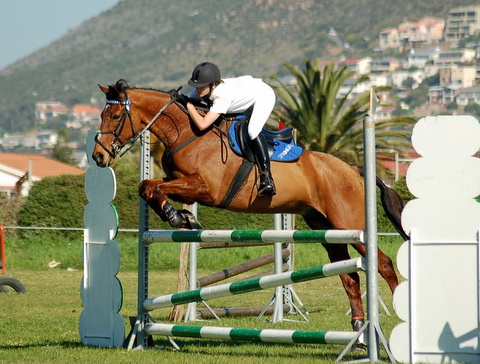

In [ ]:
from PIL import Image
Image.open(dsets.train[1][0])

In [ ]:
dblock = DataBlock(blocks = (ImageBlock,         # 유효한 이미지 경로를 입력
                             MultiCategoryBlock  # CategoryBlock은 단일 정수만을 반환하기에 다중 레이블을 반환하도록 함(one-hot encoding)
                             ),
                   get_x = get_x, get_y = get_y, splitter = splitter)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
dsets.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

### DataLoaders
DataLoader는 Dataset에 포함된 항목들을 미니배치 형태로 모아준다. -> tensor

In [ ]:
dblock = DataBlock(blocks = (ImageBlock,MultiCategoryBlock),
                   get_x = get_x, 
                   get_y = get_y, 
                   splitter = splitter,
                   item_tfms = RandomResizedCrop(128,min_scale=0.35))
dls = dblock.dataloaders(df)

In [ ]:
dls.train.one_batch()[0].shape

torch.Size([64, 3, 128, 128])

<Figure size 288x288 with 0 Axes>

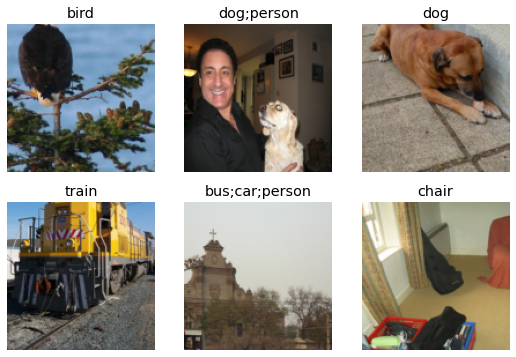

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
dls.show_batch(nrows=2,ncols=3)

## Learner
- 모델
- DataLoaders
- optimizer
- loss function

In [ ]:
learn = cnn_learner(dls, resnet18)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
x,y = dls.train.one_batch()
learn.to('cuda:0')   # data type을 맞춰준다. (torch.cuda.FloatTensor, torch.FloatTensor)
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [ ]:
activs[0]

TensorBase([-3.1315,  2.7297, -4.6729, -0.5354,  1.2181,  2.6281, -0.8942,  0.9107,  1.9072, -1.0570, -0.3146,  3.1969, -4.4717, -1.2453, -2.5541,  1.2783, -0.0497,  5.2892,  2.6455, -2.8643],
       device='cuda:0', grad_fn=<AliasBackward0>)

softmax에서는 모든 예측값이 1이 되도록 강제함과 동시에 예측값 중 하나를 exp함수를 통해 다른 값보다 훨씬 크게 만드는 경향이 있다. 하지만 다중 레이블 문제에서는 이미지 내 존재하는 여러 물체에 대한 각각의 신뢰도를 구해야 하기 때문에 총합이 1이 되도록 강제하는 방법은 유용하지 않다.<br>
\+ 이미지가 미리 정한 범주에 속하지 않을 때에는 예측의 총합을 1미만으로 만들어야할 수도 있다.

softmax는 multiclassfication에 대해서 사용하는 손실이지, multilabeled 문제에서는 의미가 없다.

In [ ]:
def binary_cross_entropy(inputs,targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

torch.nn.BCELoss와 F.binary_cross_entropy는 one-hot encoding된 target의 cross-entropy를 계산하지만, 초기에 sigmoid를 적용하지는 않는다.

일반적으로 one-hot encoding된 target에는 sigmoid 및 binary cross entropy를 모두 포함한 F.binary_cross_entropy_with_logits 또는 torch.nn.BCEWithLogitsLoss를 사용한다.

In [ ]:
# fastai에서는 자동으로 이 함수를 손실 함수로 사용
loss_func = torch.nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0431, device='cuda:0', grad_fn=<AliasBackward0>)

다중 레이블 문제를 풀기 위해 출력 활성에 sigmoid를 적용 후 활성 중 어떤 값을 0 혹은 1로 간주할지 정하는 threshold를 선택해야 한다.

In [ ]:
def accuracy_multi(inp, targ, threshold=0.5, sigmoid=True):
    if sigmoid:
        inp = inp.sigmoid()
    return ((inp>threshold)==targ.bool()).float().mean()

# partial은 함수의 일부 인자에 고정값을 할당하는 새로운 버전의 함수를 생성(python 기본 함수임)
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi,threshold=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941011,0.688469,0.239243,00:28
1,0.824477,0.567615,0.282171,00:29
2,0.598868,0.208139,0.805936,00:30
3,0.358743,0.127004,0.942789,00:29


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134346,0.114897,0.944383,00:32
1,0.119174,0.109798,0.953845,00:30
2,0.098578,0.105154,0.952749,00:30


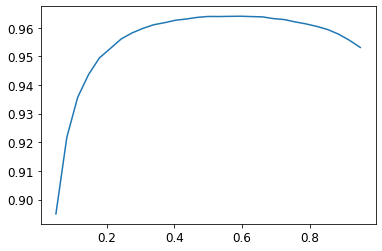

In [ ]:
# 다음과 같이 최적의 임계점을 찾을 수 있다.
# 단, 최적의 임계값을 찾기 위한 시도를 너무 많이 하면 검증용 데이터셋에도 과적합될 위험이 있다.
xs = torch.linspace(0.05,0.95, 29)
preds, targs = learn.get_preds()
accs = [accuracy_multi(preds,targs, threshold=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

# 곡선이 부드러운 형태이므로 부적합한 이상치를 선택하지 않을듯

# 회귀
이미지 회귀 : 독립변수에는 이미지, 종속변수에는 하나 이상의 부동소수를 둔 데이터셋에 대한 학습<br>
--> 확장 : 이미지상의 특정 위치를 의미하는 key point를 찾는 모델을 만듦<br>
(ex) 사람 이미지에서 얼굴의 정중앙을 찾아냄)

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
# 1~24의 숫자에 해당하는 디렉토리 24개와 .obj 파일이 있음
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/09.obj'),Path('/root/.fastai/data/biwi_head_pose/23.obj'),Path('/root/.fastai/data/biwi_head_pose/15'),Path('/root/.fastai/data/biwi_head_pose/20.obj'),Path('/root/.fastai/data/biwi_head_pose/17'),Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/21'),Path('/root/.fastai/data/biwi_head_pose/22'),Path('/root/.fastai/data/biwi_head_pose/13.obj'),Path('/root/.fastai/data/biwi_head_pose/03')...]

In [ ]:
# 디렉토리 내부에는 서로 다른 프레임을 나타내는 데이터가 있음
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00209_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00119_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00073_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00149_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00437_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00127_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00131_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00212_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00413_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00405_rgb.jpg')...]

In [ ]:
img_files = get_image_files(path)

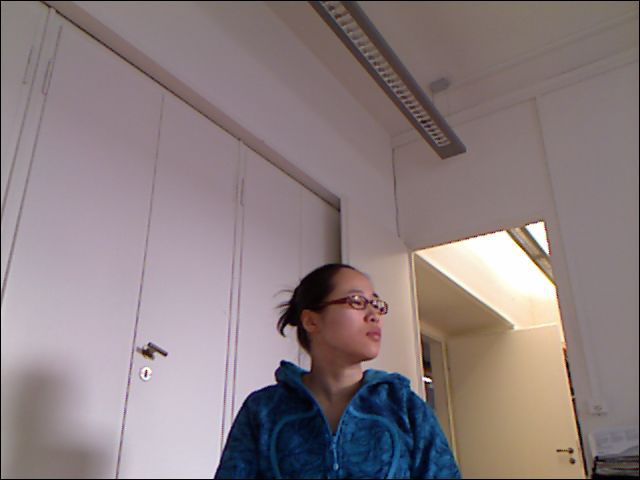

In [ ]:
Image.open(img_files[2])

In [ ]:
# 다음 함수를 통해 이미지 파일명에 해당하는 포즈 파일명을 반환하는 기능을 한다.
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/15/frame_00209_pose.txt')

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

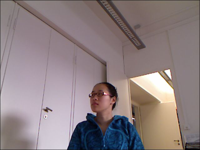

In [ ]:
im.to_thumb(200)

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal',skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    # 파일 내의 세부 사항에 대한 설명은 생략
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return torch.tensor([c1,c2])

In [ ]:
from IPython.display import display

In [ ]:
display(cal)
display(np.genfromtxt(img2pose(img_files[0]), skip_header=3))
# 각 입력 이미지의 레이블(좌표)를 반환
display(get_ctr(img_files[0]))

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

array([  20.6152,  138.923 , 1082.79  ])

tensor([329.8561, 306.9187], dtype=torch.float64)

한 사람의 이미지가 여러번 등장하므로 학습과 검증 데이터셋을 임의로 분리해서는 안된다. 검증용 데이터셋으로는 한 사람의 이미지만 사용하는 방법을 생각해볼 수 있다.

In [ ]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock),      # PointBlock을 사용하면 fastai는 레이블이 좌표로 표현된다는 사실을 파악함->데이터 증강 시 좌표에도 증강을 적용
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o:o.parent.name=='13'),  # 13번 인물만 검증셋으로 사용
    batch_tfms = [*aug_transforms(size=(240,320)),
                  Normalize.from_stats(*imagenet_stats)]
)

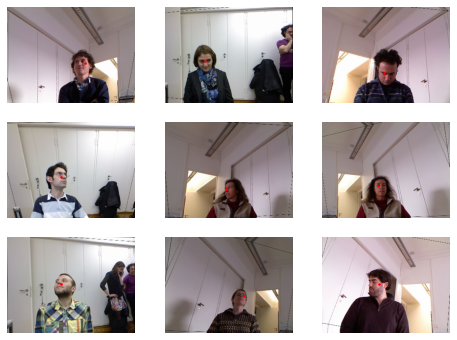

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [ ]:
# shape정보와 더불어 미니배치의 모양이 왜 이런지를 꼭 알아야
yb[0]

TensorPoint([[0.0837, 0.0828]], device='cuda:0')

## 모델 학습

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


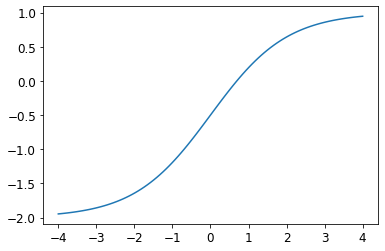

In [ ]:
# y_range라는 인자로 target의 범위를 조절
learn = cnn_learner(dls, resnet18, y_range=(-1,1))
# sigmoid의 범위를 lo와 hi 사이로 조정, fastai는 sigmoid_range 함수로 y_range를 구현
def sigmoid_range(x,lo,hi):
    return torch.sigmoid(x) * (hi-lo) + lo
plot_function(partial(sigmoid_range,lo=-2,hi=1), min=-4, max=4)

In [ ]:
# 적합한 손실함수가 사용되었는지 체크
dls.loss_func

FlattenedLoss of MSELoss()

손실함수를 따로 지정해주지 않을 경우 fastai가 자동으로 지정해준 함수가 사용되지만 순수 pytorch를 사용할 경우 손실함수를 직접 선택해야 한다.
- 단일 레이블 : nn.CrossEntropyLoss
- 다중 레이블 : nn.BCEWithLogitsLoss
- 회귀 : nn.MSELoss

SuggestedLRs(valley=0.0008317637839354575)

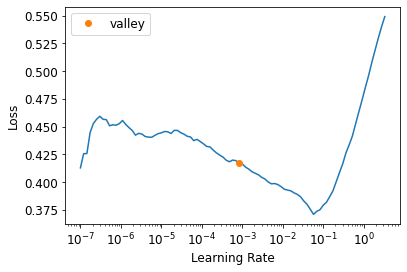

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2
learn.fine_tune(3,lr)

epoch,train_loss,valid_loss,time
0,0.047663,0.017106,02:06


epoch,train_loss,valid_loss,time
0,0.009013,0.006014,02:22
1,0.002805,0.000538,02:22
2,0.001409,0.000276,02:21


In [ ]:
# 평균 좌표 예측 오차
np.sqrt(0.000276)

0.01661324772583615

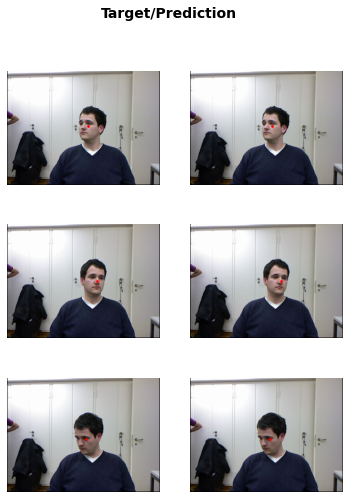

In [ ]:
# 좌측은 실제 좌표, 우측은 모델이 예측한 좌표
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))